## Project 2

Noni Arcilla

A14557003

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### 1 Implementation

In [2]:
# constants
wall = 0 # refers to track boundary
tile = 1 # refers to racetrack 
start = 2 # refers to starting positions
finish = 2.5 # refers to finish line

### Create racetrack

In [3]:
# create racetrack
track = np.ones((50,50)) # grid of dimensions 50x50

# start and finish line
track[49, 1:11] = start
track[1:7, 48] = finish

# border
track[:, 0] = wall
track[0, :] = wall
track[:, 49] = wall

# create track boundaries (walls) - bottom part
track[45:50, 11:] = wall
track[35:40, :30] = wall
track[40:42, 20:30] = wall
track[30:35, :10] = wall
track[39:42, 40:] = wall
track[30:39, 36:] = wall

# track boundaries - middle and top part
track[25:30, 25:] = wall
track[21:25, 32:] = wall
track[7:11, 26:] = wall
track[10:21, 44:] = wall

# obstacles within grid
track[22:26, 9:15] = wall
track[18:22, 6:20] = wall
track[14:18, 22:35] = wall
track[15:20, 19:24] = wall
#track[7:10, 40:44] = tile
track[3:5, 35:40] = wall
track[5:9, 15:20] = wall

# wall on top left
for i in range(1,15):
    track[i, 1:15-i] = wall

### Display racetrack

The magenta cells denote the actual racetrack.

The light cells on the bottom left denote the starting line.

The black cells denote a wall. Any agent that hits a wall gets sent back to the starting line.

The white cells on the top right denote the finish line.

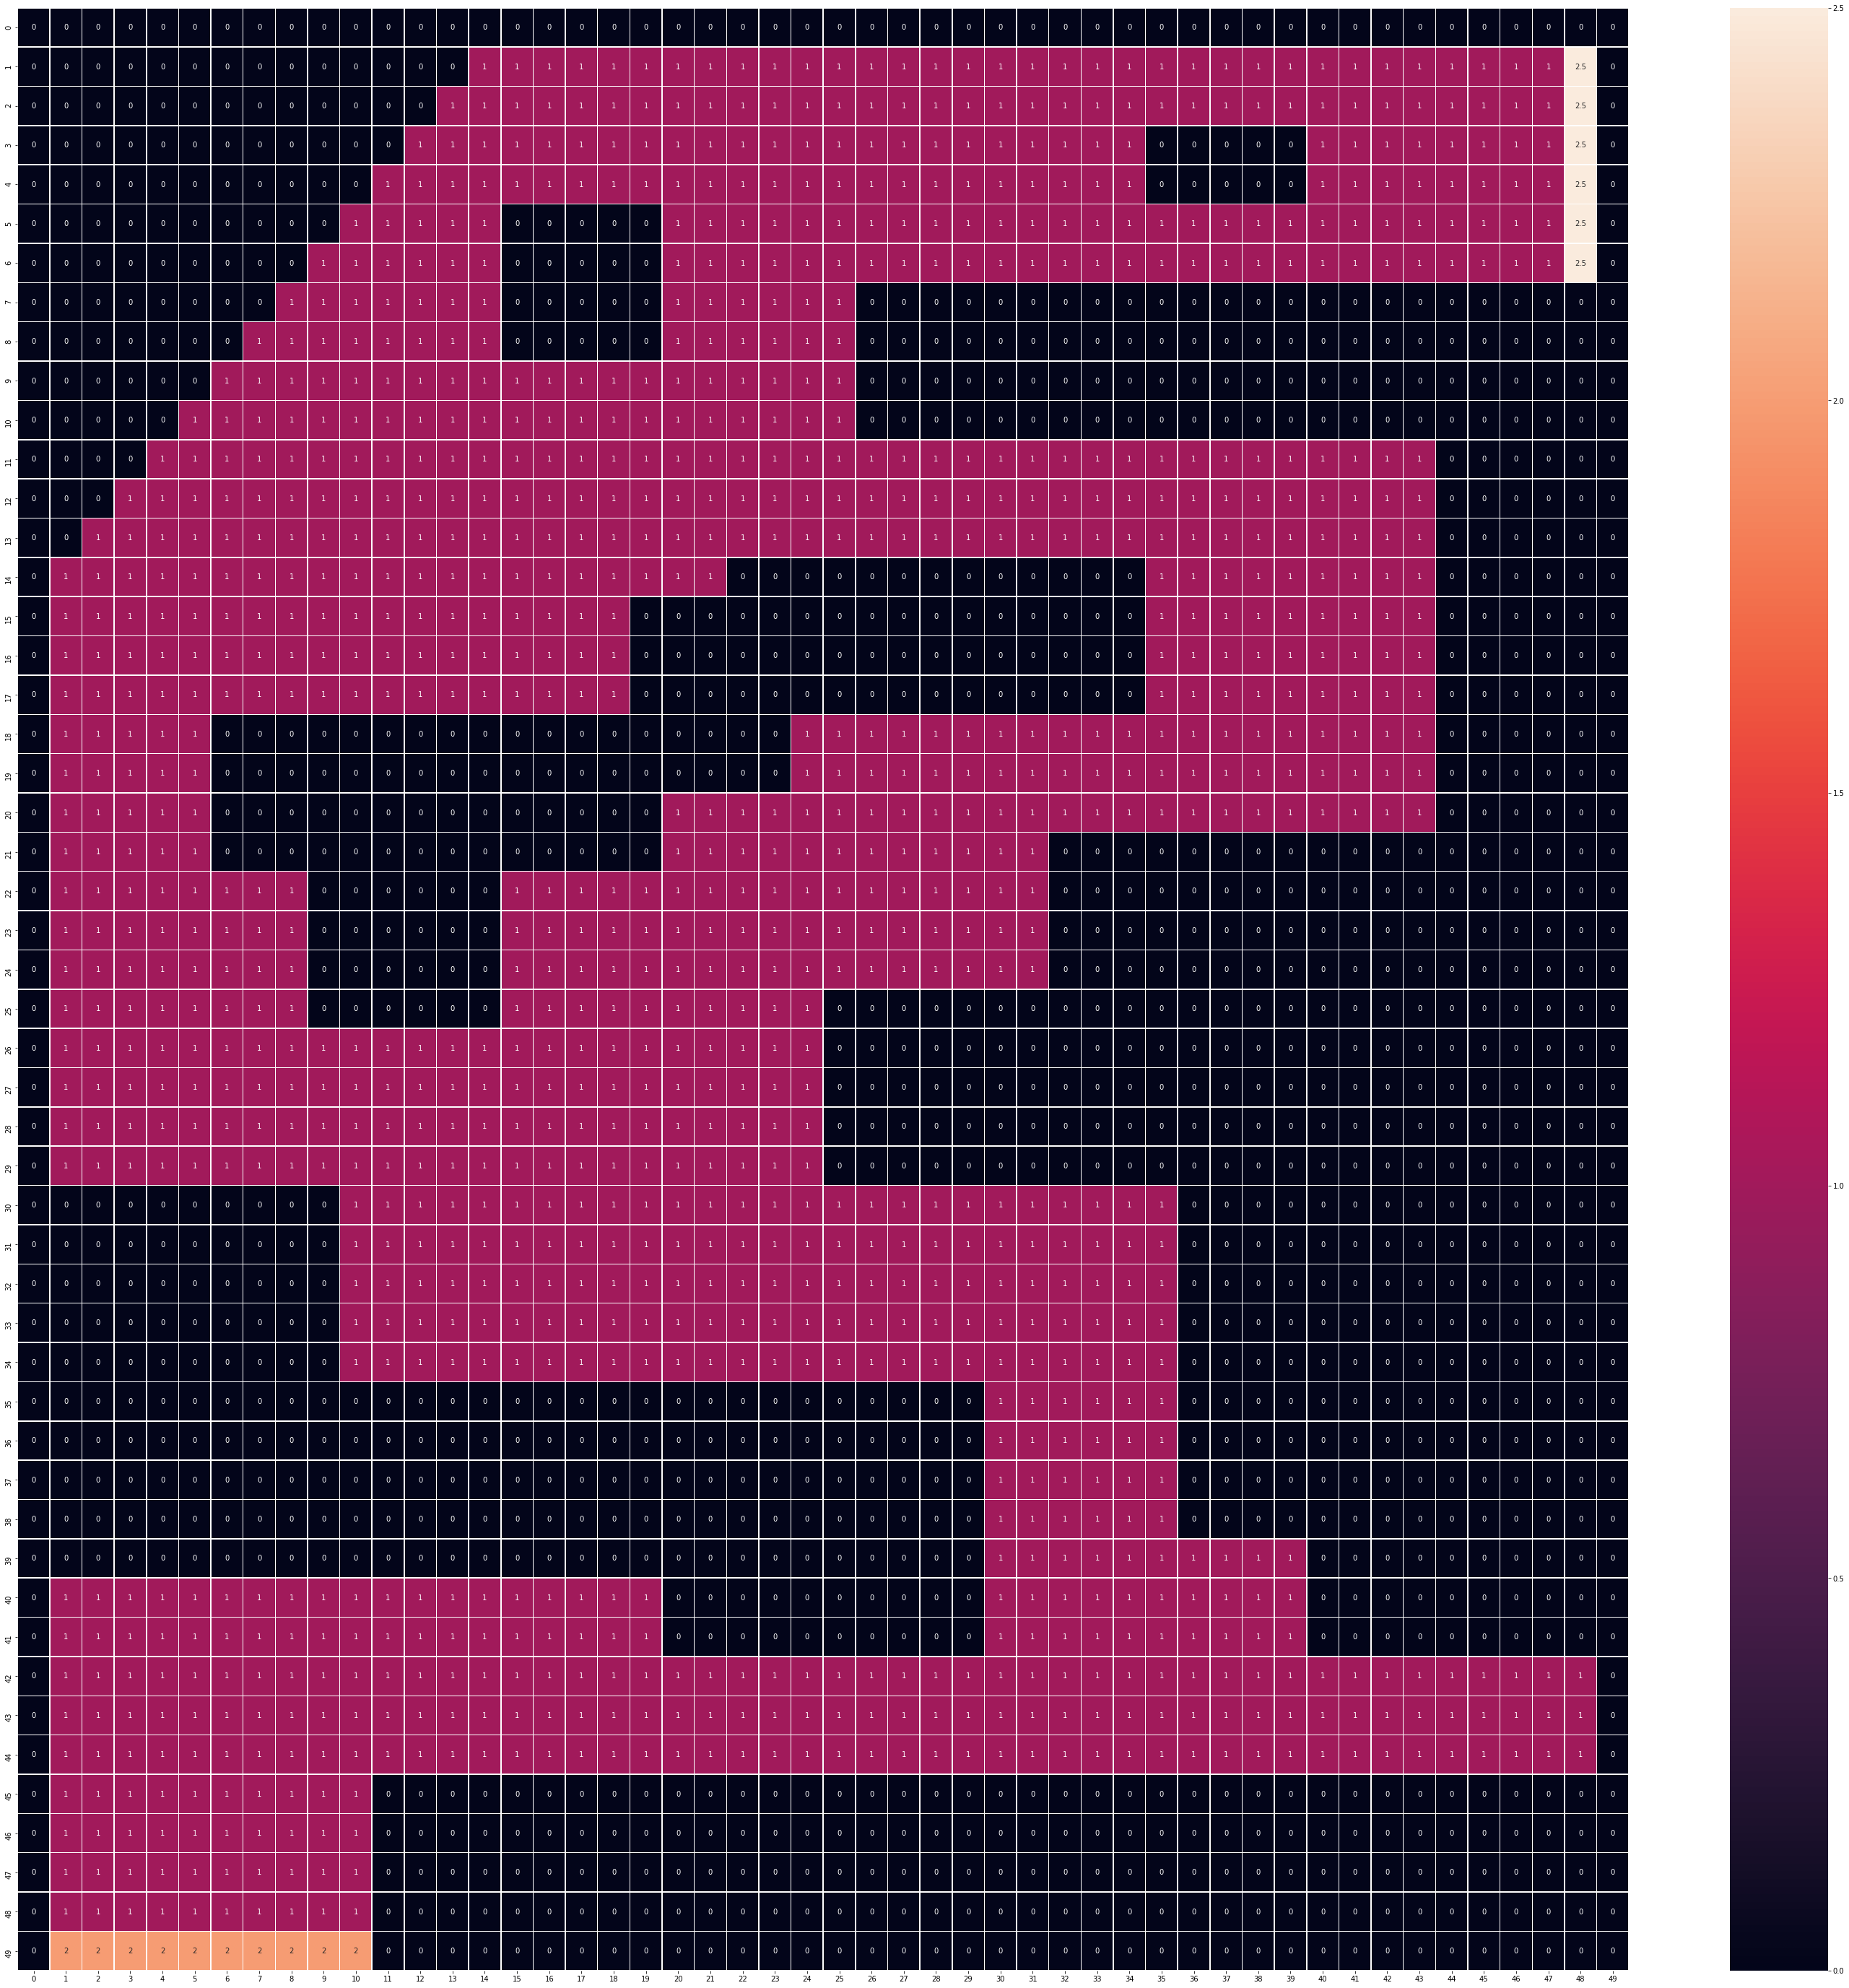

In [4]:
# Display racetrack
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(track, annot=True, linewidths=.5, ax=ax)

### Environment functions

In [5]:
# FUNCTION - returns incremented velocity (with sign denoting direction)
def find_velocity(x_velocity, y_velocity, x_inc, y_inc, right, up):
    # we assume that both velocity components are >= 0 and < 5 (i.e. cannot be < 0 or >= 5)
    
    # calculate new velocity
    x_new_vel = x_velocity + x_inc
    y_new_vel = y_velocity + y_inc
    
    # INVALID NEW VELOCITY - max velocity = 4
    if x_new_vel >= 5:
        x_new_vel = x_velocity + random.choice([0, -1])
    if y_new_vel >= 5:
        y_new_vel = y_velocity + random.choice([0, -1])
        
    # INVALID NEW VELOCITY - min velocity = 0
    if x_new_vel < 0:
        x_new_vel = x_velocity + random.choice([0, 1])
    if y_new_vel < 0:
        y_new_vel = y_velocity + random.choice([0, 1])
        
    # INVALID NEW VELOCITY - min velocity is 0 for one component and 1 for the other component (cannot both be zero)
    if x_new_vel == 0 and y_new_vel == 0:
        change_x = random.choice([True, False])
        if change_x:
            x_new_vel += 1
        else:
            y_new_vel +=1
            
    # 0.1 probability that the velocity increments are both zero
    if np.random.random() <= 0.1:
        x_new_vel = x_velocity
        y_new_vel = y_velocity
        
    # directions
    if not right:
        x_new_vel *= -1
    if up:
        y_new_vel *= -1
        
    return x_new_vel, y_new_vel

In [6]:
# FUNCTION - given state and action, return next state and reward
# state = current (x_pos, y_pos, x_velocity, y_velocity)
# action = (how much to increment x_velocity, increment of y_velocity, right, up)
# for action up, if up == True, then the agent goes up, else it goes down, and similar reasoning for right
def step(x_pos, y_pos, x_velocity, y_velocity, x_inc, y_inc, right, up):
    # calculate velocity
    x_new_vel, y_new_vel = find_velocity(x_velocity, y_velocity, x_inc, y_inc, right, up)
    
    # new positions
    x_new_pos = x_pos + x_new_vel
    y_new_pos = y_pos + y_new_vel
    
    # terminal state condition - check if crossed finish line
    if x_new_pos >= 48 and y_new_pos in range(1,7):
        return 'T', -1
    
    # check out of bounds - return to starting position
    out_of_bounds = (x_new_pos not in range(50)) or (y_new_pos not in range(50))
    if out_of_bounds:
        x_new_pos = random.choice(range(1,11))
        y_new_pos = 49
        return (x_new_pos, y_new_pos, np.abs(x_new_vel), np.abs(y_new_vel)), -1
    
    # check if car hits a boundary - return to starting position
    hit_boundary = (track[y_new_pos][x_new_pos] == wall)
    if hit_boundary:
        x_new_pos = random.choice(range(1,11))
        y_new_pos = 49
        return (x_new_pos, y_new_pos, np.abs(x_new_vel), np.abs(y_new_vel)), -1
    
    # everything valid, so return new positions and velocities
    return (x_new_pos, y_new_pos, np.abs(x_new_vel), np.abs(y_new_vel)), -1

Test the environment functions

In [7]:
# find_velocity function

for i in range(100):
    # normal case - test different directions
    assert find_velocity(2, 3, 1, 1, True, True) in [(2,-3), (3,-4)]
    assert find_velocity(2, 3, 1, 1, True, False) in [(2,3), (3,4)]
    assert find_velocity(2, 3, 1, 1, False, True) in [(-2,-3), (-3,-4)]
    assert find_velocity(2, 3, 1, 1, False, False) in [(-2,3), (-3,4)]

    # test minimum velocity and invalid minimum velocity (both zeros)
    assert find_velocity(0, 1, 0, 0, True, False) == (0,1)
    assert find_velocity(0, 0, -1, 1, True, False) in [(0,0), (1,0), (0,1), (1,1)]

    # test invalid cases
    assert find_velocity(0, 0, -1, 1, True, True) in [(0,0), (1,0), (0,-1), (1,-1)] # incremented x velocity goes below limit
    assert find_velocity(0, 0, 0, -1, False, True) in [(0,0), (0,-1), (-1,0)] # incremented y velocity goes below limit
    assert find_velocity(0, 4, 0, 1, False, True) in [(0,-4), (0,-3)] # incremented y velocity goes above limit
    assert find_velocity(4, 4, 1, 1, False, True) in [(-4,-4), (-4,-3), (-3,-4), (-3,-3)] # incremented x and y velocity goes above limit
    assert find_velocity(0, 0, 0, 0, True, True) in [(0,0), (0,-1), (1,0)] # both velocity components are zero
    assert find_velocity(1, 1, -1, -1, True, True) in [(1,-1), (1,0), (0,-1)] # both velocity components are zero

In [8]:
# step function

# output to file
with open('checkStep', 'w') as f:
    print('This file tests the step function to ensure correct outputs are printed for various types of inputs.\n', file=f)
    print('States are of the form: (current x-position, current y-position, current x-velocity, current y-velocity).',
          'The x- and y- positions are an index on the 2D numpy array used to represent the grid.',
          'The x- and y- velocities are how many tiles horizontally and vertically the agent moves.', file=f)
    print('Actions are of the form: (x-velocity increment, y-velocity increment, right, up), where if right==True,',
          'then the agent goes right, otherwise it goes left, and same with up.', file=f)
    print("'correct output' is either 'yes' or 'no'. If yes, it means that the step function returns the intended output.\n", file=f)

    # create lists of states, actions, new states, new rewards, and booleans for correct outputs
    states = [(2, 47, 2, 3), (21, 43, 4, 1), (14, 12, 0, 2), (36, 2, 2, 0), (1, 49, 4, 1), (47, 43, 3, 0),
              (3, 12, 4, 4), (16, 3, 1, 2), (37, 2, 0, 2), (22, 2, 4, 2), (10, 26, 0, 1), (43, 2, 4, 0),
              (44, 2, 4, 1), (45, 6, 4, 4), (48, 6, 4, 4)]
    actions = [(0,0,True,True), (-1,0,True,True), (1,0,False,False), (1,1,True,True), (0,0,False,False),
               (0,0,True,True), (0,0,False,True), (0,0,True,False), (0,0,True,False)] + [(0,0,True,True) for i in range(6)]
    actual_outputs = [ [((4, 44, 2, 3), -1)], 
                       [((25, 42, 4, 1), -1), ((24, 42, 3, 1), -1)],
                       [((14, 14, 0, 2), -1), ((13, 14, 1, 2), -1)],
                       [((38, 2, 2, 0), -1), ((39, 1, 3, 1), -1)],
                       [((i, 49, 4, 1), -1) for i in range(1,11)],
                       [((i, 49, 3, 0), -1) for i in range(1,11)],
                       [((i, 49, 4, 4), -1) for i in range(1,11)],
                       [((i, 49, 1, 2), -1) for i in range(1,11)],
                       [((i, 49, 0, 2), -1) for i in range(1,11)],
                       [((i, 49, 4, 2), -1) for i in range(1,11)],
                       [((i, 49, 0, 1), -1) for i in range(1,11)],
                       [((47, 2, 4, 0), -1)],
                       [('T', -1)], 
                       [('T', -1)],
                       [('T', -1)] ]
    
    # print to file
    print('GENERAL FORM: state | action | new state | reward | correct output', file=f)
    for i in range(len(states)):
        # the current state and action
        s = states[i]
        a = actions[i]
        
        output = step(s[0], s[1], s[2], s[3], a[0], a[1], a[2], a[3])
        
        s_prime = output[0]
        r = output[1]
        
        # check output
        correct_output = 'no'
        if output in actual_outputs[i]:
            correct_output = 'yes'
            
        # print to file
        print(s, '|', a, '|', s_prime, '|', r, '|', correct_output, file=f)
    print('\n', file=f)

    
    # output frequencies - there's a 0.1 probability that the velocity increments are zero
    # check output frequencies for 2 states on the grid
    print("Output frequencies for 2 states: there's a 0.1 probability that the velocity increments (action) are zero.", file=f)
    s1_a1 = (27, 11, 1, 4, 1, -1, False, True)
    s2_a2 = (45, 4, 2, 2, 1, 1, True, True)
    freqs = np.zeros((2,2))
    for i in range(1000):
        output_1 = step(s1_a1[0], s1_a1[1], s1_a1[2], s1_a1[3], s1_a1[4], s1_a1[5], s1_a1[6], s1_a1[7])
        output_2 = step(s2_a2[0], s2_a2[1], s2_a2[2], s2_a2[3], s2_a2[4], s2_a2[5], s2_a2[6], s2_a2[7])
        
        # output_1
        if output_1[0][0] in range(1,11): # hit a wall
            freqs[0][0] += 1
        else:
            freqs[0][1] += 1
            
        # output_2
        if output_2[0] == 'T':
            freqs[1][0] += 1
        else:
            freqs[1][1] += 1
            
    freqs /= 1000
    
    print('FORM: state | action | new state | reward | output frequency', file=f)
    print('(27, 11, 1, 4) | (1, -1, False, True) | (25, 8, 2, 3) | -1 | {}'.format(freqs[0][1]), file=f)
    print('(27, 11, 1, 4) | (1, -1, False, True) | starting line | -1 | {}'.format(freqs[0][0]), file=f)
    print('(45, 4, 2, 2) | (1, 1, True, True) | (47, 2, 2, 2) | -1 | {}'.format(freqs[1][1]), file=f)
    print('(45, 4, 2, 2) | (1, 1, True, True) | finish line | -1 | {}'.format(freqs[1][0]), file=f)

## Algorithms

### Q-learning

In [ ]:
# constants
epsilon = 
alpha = 
n_eps = 

grid_size = 50
num_vels = 5
vel_incs = 3
directions = 2

start_y_pos = 49

In [ ]:
# initializations
Q = np.zeros((grid_size, grid_size, num_vels, num_vels, vel_incs, vel_incs, directions, directions))
V = np.zeros((grid_size, grid_size, num_vels, num_vels))

In [ ]:
# FUNCTION - 
def choose_action():
    

In [ ]:
for e in range(n_eps):
    # states are of the form (x_coordinate, y_coordinate, x_velocity, y_velocity)
    # actions are of the form (x_increment_to_velocity, y_increment_to_velocity, right?, up?)
    
    # begin in one of the positions on the starting line
    x_pos = random.choice(range(1,11))
    y_pos = start_y_pos
    x_velocity = 0
    y_velocity = 0
    s = (x_pos, y_pos, x_velocity, y_velocity)
    
    # loop through each step of episode until car crosses finish line
    while s[0] != 'T':
        a = choose_action() # choose a from s
        output = step(s[0], s[1], s[2], s[3], a[0], a[1], a[2], a[3]) # take action a
        s_prime = output[0]
        r = output[1]
        
        # Q-learning
        Q[x_pos][y_pos][x_velocity][y_velocity][]